In [14]:
import sys

!{sys.executable} -m pip install setuptools
!{sys.executable} -m pip install python-dotenv
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install mlflow
!{sys.executable} -m pip install dagshub
!{sys.executable} -m pip install keras-tuner
!{sys.executable} -m pip install scikeras


[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import mlflow
import mlflow.tensorflow
import dagshub
from scipy.stats import randint, loguniform

In [33]:
# set up dagshub for mlflow tracking
dagshub.init(repo_owner='JonaKoenemann', repo_name='machine_failure_classification', mlflow=True)

Initialized MLflow to track repo "JonaKoenemann/machine_failure_classification"

Repository JonaKoenemann/machine_failure_classification initialized!

# Data preparation

In [34]:
# Load data
data_path = "../../../data/predictive_maintenance.csv"
df = pd.read_csv(data_path)

In [35]:
# Define features
categorical_features = ['Type']
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_features.remove('UDI')
numerical_features.remove('Target')

# Preprocessing
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
            # ('poly', poly)
        ]), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [47]:
# Split data
X = df[numerical_features + categorical_features]
y = df["Failure Type"]

# Encode target variable as categorical
y_encoded = pd.get_dummies(y).values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Verify the shape of the transformed data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print("Transformed X_train shape:", X_train_transformed.shape)
print("Transformed X_test shape:", X_test_transformed.shape)

Transformed X_train shape: (8000, 8)
Transformed X_test shape: (2000, 8)


# Model creation

In [48]:
mlflow.set_experiment("neural_net_rs_feature")

<Experiment: artifact_location='mlflow-artifacts:/5d070a7a848a4292978b8f295b25d38f', creation_time=1718893734590, experiment_id='6', last_update_time=1718893734590, lifecycle_stage='active', name='neural_net_rs_feature', tags={}>

In [49]:
# Define the model for multi-class classification
def create_model(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(6, input_dim=input_dim, activation=None))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(6, activation='softmax'))  # 6 output units for 6 classes
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [50]:
# Wrap the model using KerasClassifier
model = KerasClassifier(model=create_model, input_dim=X_train_transformed.shape[1], verbose=0)

# Train and test

In [51]:
# Create a pipeline that includes preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [52]:
# # Define RandomizedSearchCV
# param_dist = {
#     'classifier__batch_size': [10, 20, 40, 60, 80, 100],
#     'classifier__epochs': [10, 50, 100],
#     'classifier__optimizer': ['adam', 'rmsprop']
# }
# Define hyperparameters distribution
param_dist = {
    # 'model__learning_rate':loguniform(0.001, 0.1),
    'model__batch_size': randint(16, 65),
    'model__epochs': randint(10, 31),
    'model__optimizer': ['SGD', 'Adam'],
}

In [53]:
randomized_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, cv=3, n_iter=50, scoring='f1_weighted', verbose=1)

In [54]:
mlflow.set_experiment("neural_net_rs_feature_encoded_encoded")
mlflow.tensorflow.autolog()

In [55]:
with mlflow.start_run() as run:
    # Fit RandomizedSearchCV
    randomized_search.fit(X_train, y_train)

    # Get the best parameters
    best_params = randomized_search.best_params_
    mlflow.log_params(best_params)
    print(f"\nbest params: {best_params}")

    # Get the best model
    best_model = randomized_search.best_estimator_

    # predicition
    y_pred = best_model.predict(X_test)

    # evaluation
    weighted_f1 = f1_score(y_true = y_test, y_pred = y_pred, average="weighted")
    print("\nweighted f1 score:", weighted_f1)
    mlflow.log_metric('weighted_f1_score', weighted_f1)
    
    mlflow.end_run()

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2024/07/04 22:01:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:04 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:05 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not availab

2024/07/04 22:01:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:48 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:49 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:01:50 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not availab

2024/07/04 22:02:29 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:02:30 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:02:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
2024/07/04 22:02:31 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not availab


best params: {'model__batch_size': 18, 'model__epochs': 25, 'model__optimizer': 'Adam'}

weighted f1 score: 0.9710208484520485


# Evaluation

In [56]:
error_names = [
 'Heat Failure',
 'No Failure',
 'Overstrain Failure',
 'Power Failure',
 'Random Failure',
 'Tool wear Failure'] # get names of errors in correct order for confusion matrix

## Classification report

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.39      0.60      0.47        15
           1       0.98      0.99      0.99      1935
           2       0.78      0.54      0.64        13
           3       0.92      0.60      0.73        20
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        11

   micro avg       0.97      0.97      0.97      2000
   macro avg       0.51      0.46      0.47      2000
weighted avg       0.97      0.97      0.97      2000
 samples avg       0.97      0.97      0.97      2000



c:\Users\jkoenemann\GitHub\machine_failure_classification\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Normalized confusion matrix

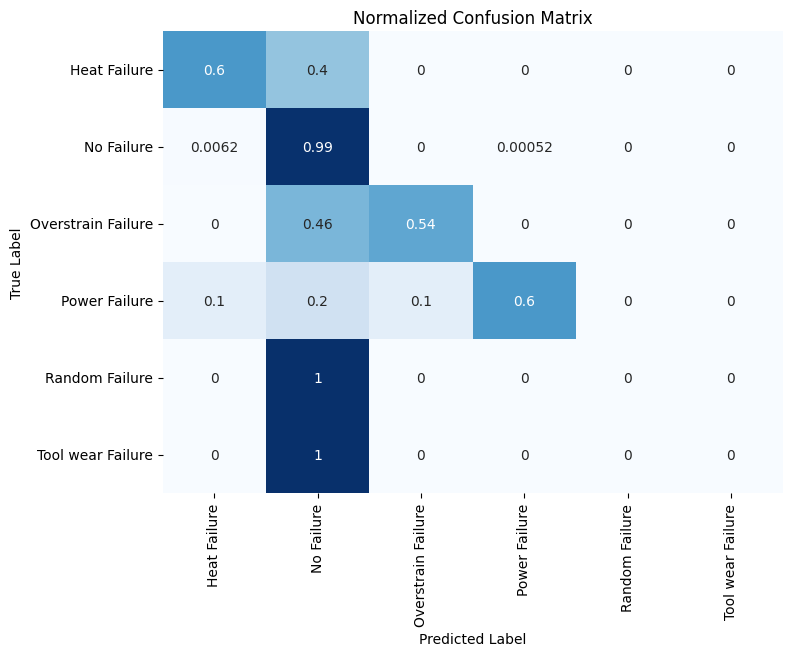

In [58]:
# Convert predictions and true labels to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the normalized confusion matrix
conf_matrix_normalized = confusion_matrix(y_true_classes, y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", cbar=False, xticklabels=error_names, yticklabels=error_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.show()